# Core Level Spectroscopy
## Taller 3 Punto 9

### (a)

#### Carga y entendimiento de los datos


In [950]:
import os
import numpy as np
import matplotlib.pyplot as plt

# se espera que el archivo esté en formato .txt (llamado "data.txt") y que esté en la carpeta "data"
data_path = os.path.join('data', 'data.txt')

In [951]:
# diccionario con metadatos
metadata = {}
energy = [] # (keV)
counts = []
background = []
fit = []

with open(data_path, 'r') as file:

    # se obtiene la metadata
    for _ in range(50):  # Solo las primeras 50 líneas que tienen la metadata
        line = file.readline()
        # se divide la línea por ':'
        key, value = [item.strip() for item in line.split(':', 1)]

        if key not in metadata:
            metadata[key] = value
        else: # por si hay dos valores con el mismo nombre
            key = key + '_1'
            metadata[key] = value

    # se ignora la línea de encabezados
    ignore_line = file.readline()  

    # hacer loop hasta llegar al final del archivo obteniendo los datos
    while True:
        line = file.readline()
        if not line:
            break
        # se divide la línea por espacios en blanco y se remueven las comas para convertir a float
        e, c, b, f = [float(item.replace(',','.')) for item in line.split()]
        energy.append(e)
        counts.append(c)
        background.append(b)
        fit.append(f)

# se convierten las listas a arrays de numpy
energy = np.array(energy)
counts = np.array(counts)
background = np.array(background)
fit = np.array(fit)

metadata

{'SampleIdent': 'Muestra3_JGR_190224-2',
 'TimeMeasured': '19/02/2024 13:45:13',
 'Application': '<Omnian>',
 'ConditionSet': 'Omnian',
 'Instrument': 'Epsilon3',
 'InstrumentSerial': '3060 (M-3060)',
 'TubeAnode': 'Rh 50',
 'Detector': 'SDD10',
 'kV': '50,000',
 'mA': '0,033',
 'uA': '33',
 'Filter': 'Ag 100',
 'Medium': 'Air',
 'PeakingTimeNr': '3',
 'ZeroReference': '-0,006302353460',
 'GainReference': '0,008007706143',
 'NoiseReference': '0,063759632409',
 'FanoReference': '0,136225819588',
 'ZeroInit': '-0,006286005490',
 'GainInit': '0,008007762022',
 'NoiseInit': '0,064493663609',
 'FanoInit': '0,135903120041',
 'ZeroFit': '-0,016244728118',
 'GainFit': '0,008018123917',
 'NoiseFit': '0,049300439656',
 'FanoFit': '0,152401939034',
 'NormFactor': '0,992071807384',
 'NormRefCounts': '88117,750000000000',
 'NormCurCounts': '88821,953125000000',
 'ROI-Fit (chan)': '250',
 'ROI-Fit (chan)_1': '4094',
 'Chi-square': '23,114484786987',
 'RefPressure': '741,60',
 'RefTemp': '22,900',
 '

In [952]:
# asegurarse de que los datos no hayan sido alterados cuando se vuelvan a correr las celdas
assert len(energy) == len(counts) == len(background) == len(fit) == (4147-52+1)
assert len(metadata) == 50

In [953]:
def get_energy_range(energies, energy_start, energy_end):
    # Primero, aseguramos que la lista esté ordenada
    energies.sort()
    
    # Encontramos el índice del primer valor mayor o igual a energy_start
    start_index = next((i for i, val in enumerate(energies) if val >= energy_start), None)
    
    # Encontramos el índice del último valor menor o igual a energy_end
    end_index = next((i for i, val in enumerate(reversed(energies)) if val <= energy_end), None)
    
    if start_index is None or end_index is None:
        return []  # Retorna una lista vacía si no se encuentra el rango
    
    # Ajustamos end_index al índice correcto en la lista original
    end_index = len(energies) - end_index - 1
    
    # Retornamos la sublista que incluye el rango deseado
    return start_index, end_index


#### Primer vistazo a los datos

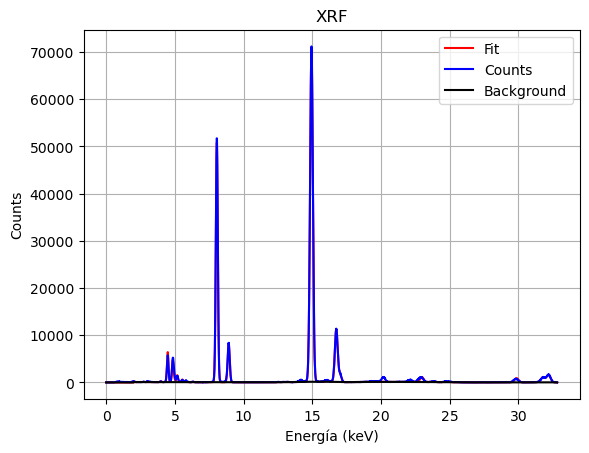

In [954]:

# graficar datos
def plot_data(energy, counts=None, background=None, fit=None, 
              initial_energy = None, final_energy = None,
              initial_index = None, final_index = None,
              peaks = None, out_energy=False, out=False, ):

    # Graficar los picos con una línea vertical punteada
    if peaks is not None:
        if out_energy:
            print('Energía de picos:')
        for peak in peaks:
            if out_energy:
                print(energy[peak])
            plt.axvline(energy[peak], color='g', linestyle='--')
    
    if initial_energy is not None and final_energy is not None:
        initial, final = get_energy_range(energy, initial_energy, final_energy)
        energy = energy[initial:final]
        plt.title(f'XRF ({initial_energy} keV - {final_energy} keV)')
    elif initial_index is not None and final_index is not None:
        initial = initial_index
        final = final_index
        energy = energy[initial:final]
        plt.title('XRF')
    else:
        initial = 0
        final = len(energy)
        plt.title('XRF')
    

    if fit is not None:
        fit = fit[initial:final]
        plt.plot(energy, fit, label='Fit', color = 'r')
    if counts is not None:
        counts = counts[initial:final]
        plt.plot(energy, counts, label='Counts', color='b')
    if background is not None:
        background = background[initial:final]
        plt.plot(energy, background, label='Background', color='k')

    plt.xlabel('Energía (keV)')
    plt.ylabel('Counts')
    plt.grid()
    plt.legend()
    plt.show()
    
    if out:
        return energy, counts #, fit

plot_data(energy, counts, background, fit)

A primera vista vemos que el fit es adecuado con los datos utilizados (a gran escala). Además, el background es insignificante.

In [955]:
# maximo de background
max_background = max(background)
print(f'El máximo de background es {max_background}')

El máximo de background es 147.8232


#### Analizaremos los picos más importantes

In [956]:
from scipy.signal import find_peaks

# Para detectar los picos, se puede usar la función find_peaks de scipy.signal
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

# Encuentra los picos
peaks, properties = find_peaks(fit, height=4*max_background)  # también se puede probar parámetros prominence y width

print("Cantidad de picos:", len(peaks))

#print("Índices de los picos:", peaks)

print("Energías de los picos:", energy[peaks])

peak_heights = fit[peaks]
#print("Alturas de los picos:", peak_heights)


Cantidad de picos: 12
Energías de los picos: [ 4.465887  4.83472   5.155445  5.532297  8.04197   8.907928 14.92954
 16.74163  22.97172  29.85929  31.80769  32.19256 ]


Energía de picos:
4.465887
4.83472
5.155445
5.532297
8.04197
8.907928
14.92954
16.74163
22.97172
29.85929
31.80769
32.19256


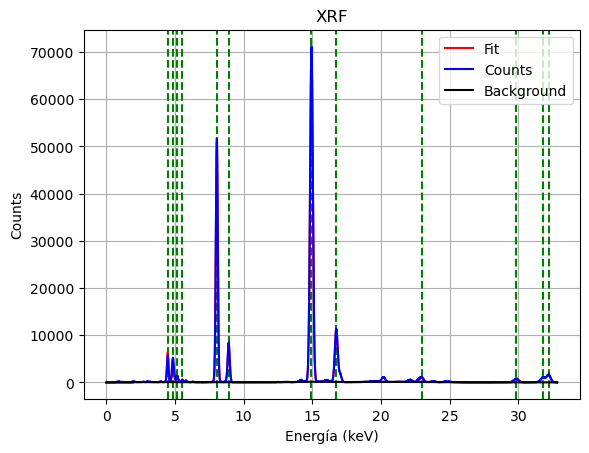

In [957]:
plot_data(energy, counts, background, fit, peaks=peaks, out_energy=True)

**Segmento 1: picos 1, 2, 3, 4**

Energía de picos:
4.465887
4.83472
5.155445
5.532297


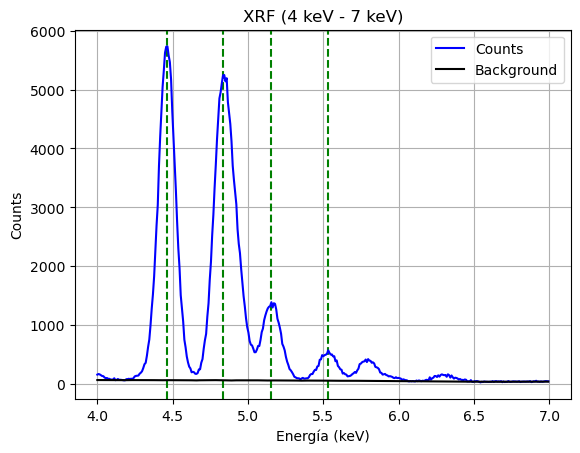

El primer pico es el Lα1 de Ba, con energía de 4.466 keV
El segundo pico es el Lβ1 de Ba, con energía de 4.83 keV
El tercer pico es el Lγ1 de Ba, con energía de 5.531 keV
El cuarto pico es el Kα1 de Fe, con energía de 6.404 keV


In [958]:
plot_data(energy, counts, background, initial_energy=4, 
          final_energy=7, peaks=peaks[:4], out_energy=True)
print("El primer pico es el Lα1 de Ba, con energía de 4.466 keV")
print("El segundo pico es el Lβ1 de Ba, con energía de 4.83 keV")
print("El tercer pico es el Lγ1 de Ba, con energía de 5.531 keV")
print("El cuarto pico es el Kα1 de Fe, con energía de 6.404 keV")

**Segmento 2: picos 5, 6**

Energía de picos:
8.04197
8.907928


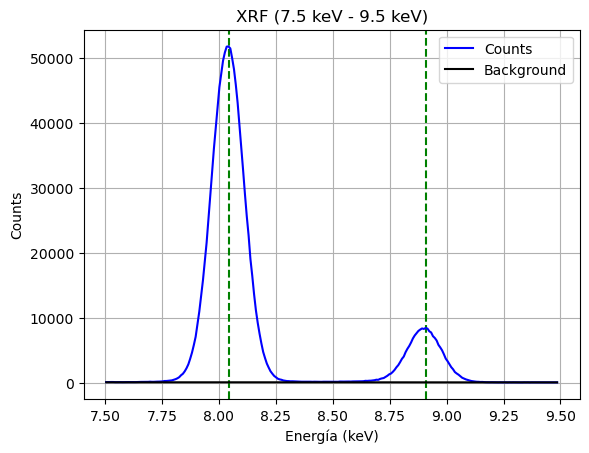

El pico izquierdo es el Kα1 de Cu, con energía de 8.04 keV
El pico izquierdo es el Kβ1 de Cu, con energía de 8.91 keV


In [959]:
plot_data(energy, counts, background, initial_energy=7.5, final_energy=9.5, peaks=peaks[4:6], out_energy=True)
print("El pico izquierdo es el Kα1 de Cu, con energía de 8.04 keV")
print("El pico izquierdo es el Kβ1 de Cu, con energía de 8.91 keV")

**Segmento 3: picos 7, 8**

Energía de picos:
14.92954
16.74163


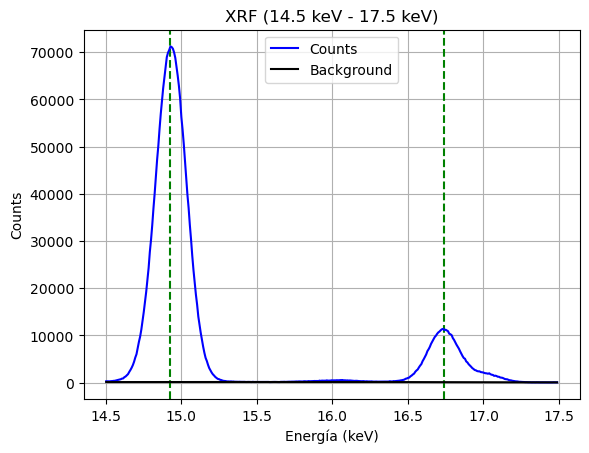

El pico principal es el Kα1 de Y, con energía de 14.96 keV
El pico derecho es el Kβ1 de Y, con energía de 16.74 keV


In [960]:
plot_data(energy, counts, background, initial_energy=14.5, final_energy=17.5, peaks=peaks[6:8], out_energy=True)
print("El pico principal es el Kα1 de Y, con energía de 14.96 keV")
print("El pico derecho es el Kβ1 de Y, con energía de 16.74 keV")

**Segmento 4: pico 9**

Energía de picos:
22.93163


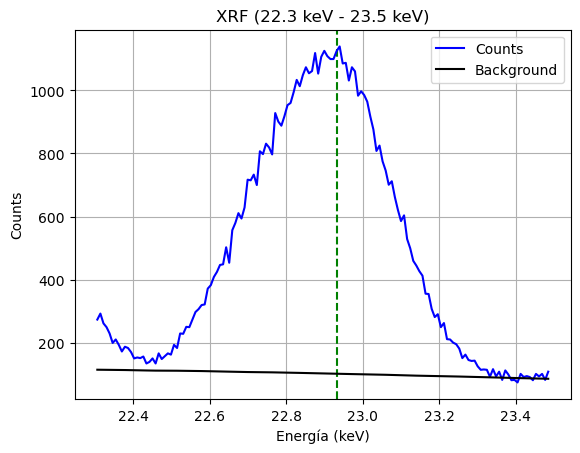

El pico es (posiblemente) el Kα2 de Cd, con energía de 22.98 keV


In [961]:
peaks[8] -= 5
plot_data(energy, counts, background, initial_energy=22.3, final_energy=23.5, peaks=peaks[8:9], out_energy=True)
print("El pico es (posiblemente) el Kα2 de Cd, con energía de 22.98 keV")


**Segmento 5: pico 10, 11, 12**

Energía de picos:
29.79514
31.80769
32.19256


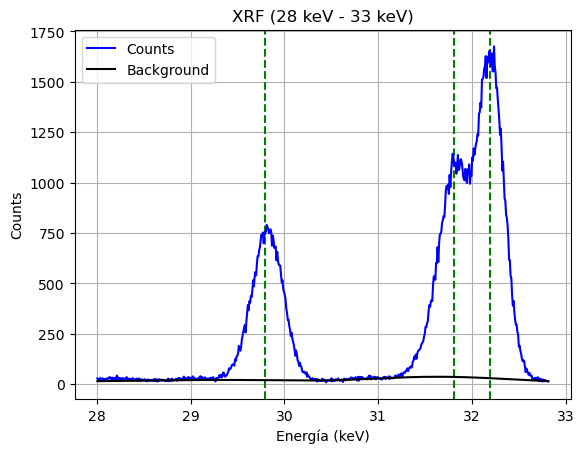

El pico derecho es el Kα1 de Ba, con energía de 32.19 keV
El pico medio es el Kα2 de Ba, con energía de 31.81 keV
El pico izquierdo es (posiblemente) el Kα1 de Xe, con energía de 29.78 keV


In [962]:
peaks[9] -= 8
plot_data(energy, counts, background, initial_energy=28, final_energy=33, peaks=peaks[9:12], out_energy=True)
print("El pico derecho es el Kα1 de Ba, con energía de 32.19 keV")
print("El pico medio es el Kα2 de Ba, con energía de 31.81 keV")
print("El pico izquierdo es (posiblemente) el Kα1 de Xe, con energía de 29.78 keV")

#### Realizamos un ajuste gaussiano para cada pico

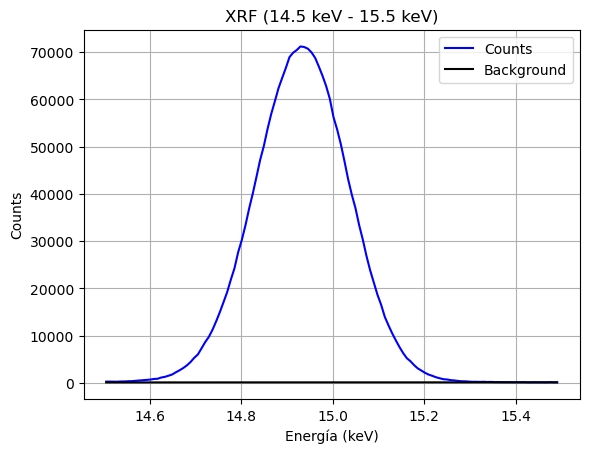

In [963]:
energy_, counts_ = plot_data(energy, counts, background, initial_energy=14.5, final_energy=15.5, out=True)

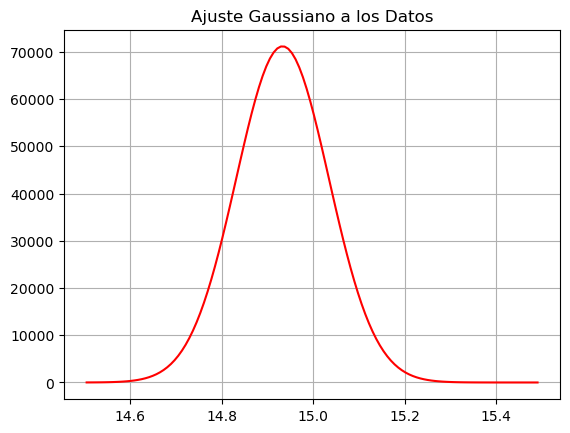

In [964]:
from scipy.optimize import curve_fit

def ajustar_gaussiano(x, y, p0):
    def gaussian(x, a, b, c):
        return a * np.exp(-0.5 * ((x - b) / c) ** 2)

    # Realizar el ajuste, con valores iniciales y límites
    popt, pcov = curve_fit(gaussian, x, y, p0=p0)

    y_ajustado = gaussian(x, *popt)
    plt.plot(x, y_ajustado, 'r-', label='Ajuste Gaussiano')
    plt.title('Ajuste Gaussiano a los Datos')
    plt.grid()
    plt.show()

    return y_ajustado

counts_a = ajustar_gaussiano(energy_, counts_, p0=[70000, 14.9, 0.5])


Calculamos el área bajo la curva:

In [965]:
from scipy.integrate import simps

# Area de toda la curva
area_total = simps(fit, energy)
print(f'El área total es {round(area_total,1)}')

El área total es 37910.9


In [966]:
# area con ajuste
area_a = simps(counts_a, energy_)
print(f'El área del pico es {round(area_a,1)}')

# area sin ajuste
area = simps(counts_, energy_)
print(f'El área del pico es {round(area,1)}')

El área del pico es 18086.8
El área del pico es 18208.8


El procedimiento para cada pico será:

In [967]:
def ajustar_area_pico(initial_energy_n, final_energy_n, p0_n):

    energy_n, counts_n = plot_data(energy, counts, background, 
                                   initial_energy=initial_energy_n, final_energy=final_energy_n, out=True)
    
    counts_n_ajustado = ajustar_gaussiano(energy_n, counts_n, p0=p0_n)
    
    # area con ajuste
    area_ajustada = simps(counts_n_ajustado, energy_n)
    print(f'El área del pico es {round(area_ajustada,1)}')

    return area_ajustada

In [968]:
area_Ba = 0
area_Fe = 0
area_Cu = 0
area_Y = 0
area_Cd = 0

#### Segmento 1

Energía de picos:
4.465887
4.83472
5.155445
5.532297


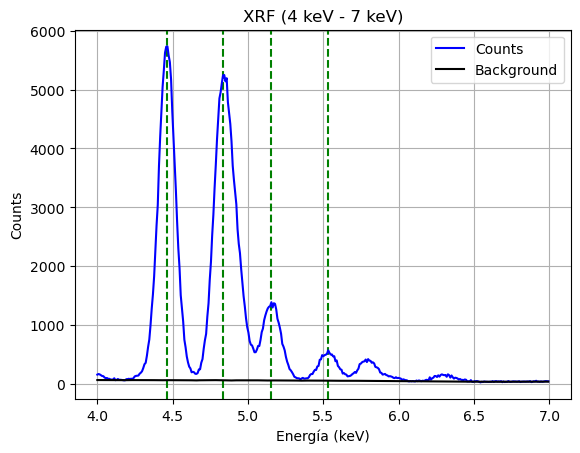

El primer pico es el Lα1 de Ba, con energía de 4.466 keV
El segundo pico es el Lβ1 de Ba, con energía de 4.83 keV
El tercer pico es el Lγ1 de Ba, con energía de 5.531 keV
El cuarto pico es el Kα1 de Fe, con energía de 6.404 keV


In [969]:
plot_data(energy, counts, background, initial_energy=4, 
          final_energy=7, peaks=peaks[:4], out_energy=True)
print("El primer pico es el Lα1 de Ba, con energía de 4.466 keV")
print("El segundo pico es el Lβ1 de Ba, con energía de 4.83 keV")
print("El tercer pico es el Lγ1 de Ba, con energía de 5.531 keV")
print("El cuarto pico es el Kα1 de Fe, con energía de 6.404 keV")

##### Pico 1

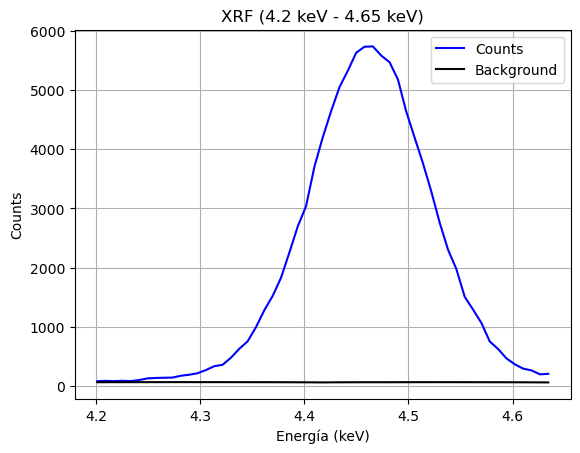

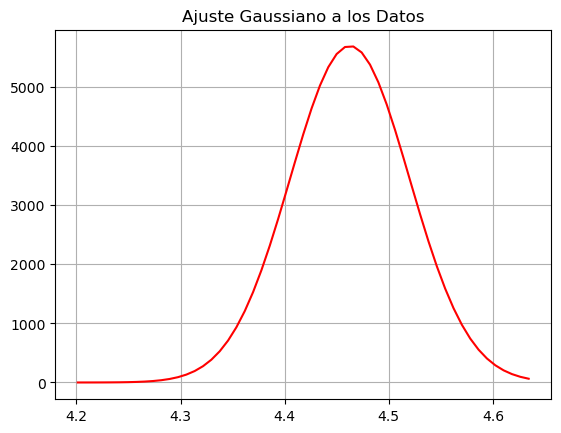

El área del pico es 816.4


In [970]:
area1 = ajustar_area_pico(4.2, 4.65, [5500, 4.5, 0.2])

##### Pico 2

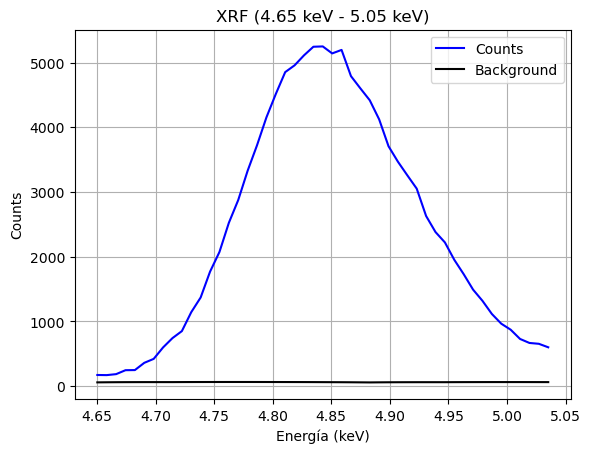

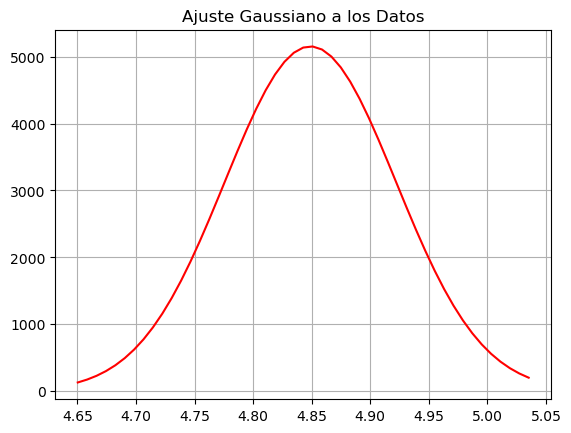

El área del pico es 936.8


In [971]:
area2 = ajustar_area_pico(4.65, 5.05, [5000, 4.8, 0.2])

##### Pico 3

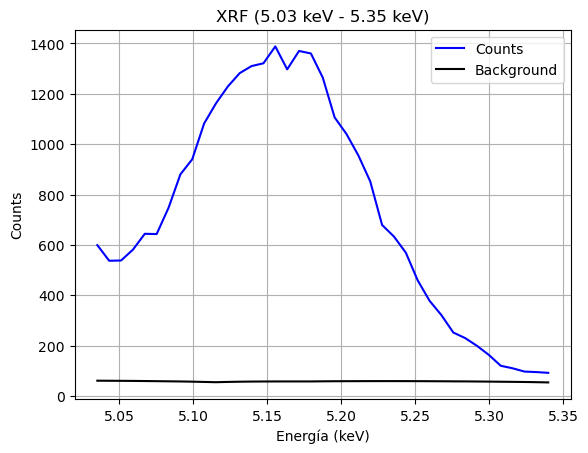

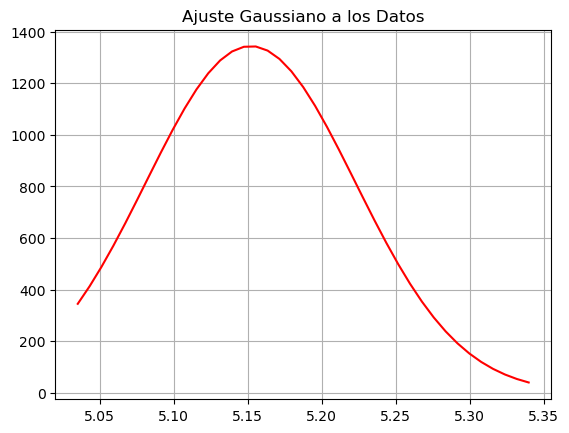

El área del pico es 225.8


In [972]:
area3 = ajustar_area_pico(5.03, 5.35, [1400, 5.15, 0.2])

##### Pico 4

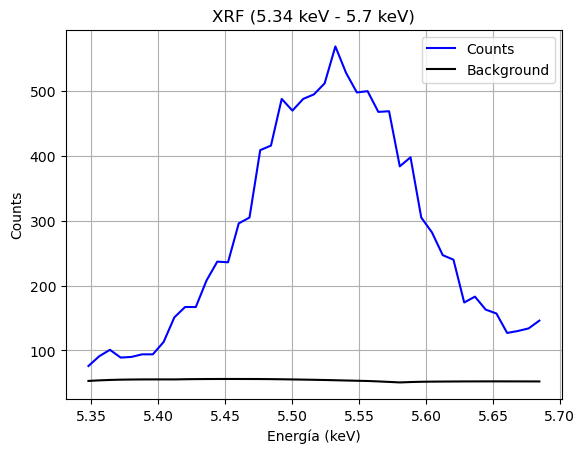

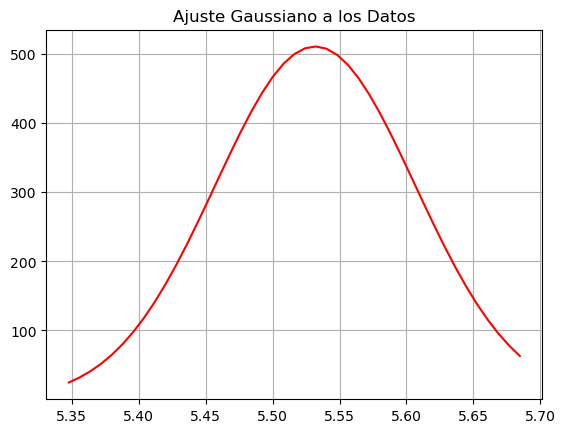

El área del pico es 93.1


In [973]:
area4 = ajustar_area_pico(5.34, 5.7, [500, 5.55, 0.2])

#### Segmento 2

Energía de picos:
8.04197
8.907928


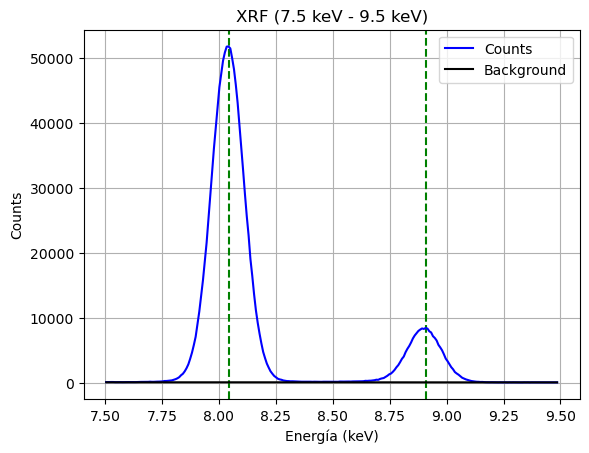

El pico izquierdo es el Kα1 de Cu, con energía de 8.04 keV
El pico izquierdo es el Kβ1 de Cu, con energía de 8.91 keV


In [974]:
plot_data(energy, counts, background, initial_energy=7.5, final_energy=9.5, peaks=peaks[4:6], out_energy=True)
print("El pico izquierdo es el Kα1 de Cu, con energía de 8.04 keV")
print("El pico izquierdo es el Kβ1 de Cu, con energía de 8.91 keV")

##### Pico 5

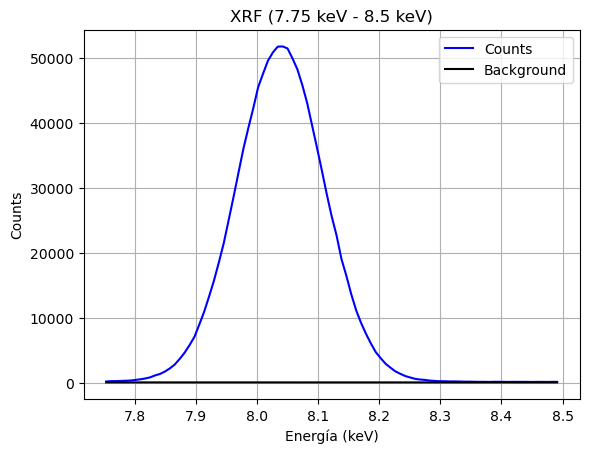

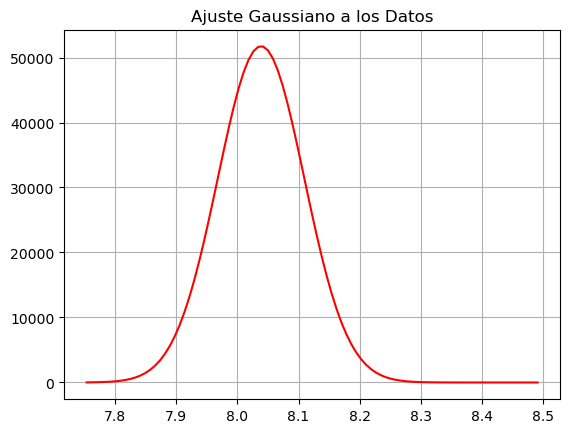

El área del pico es 9188.8


In [975]:
area5 = ajustar_area_pico(7.75, 8.5, [50000, 8.1, 0.2])

##### Pico 6

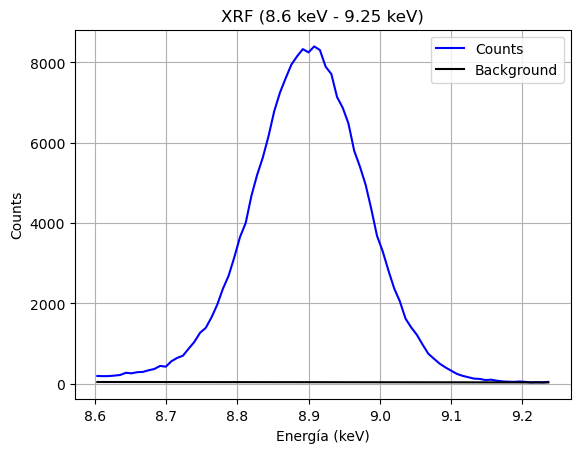

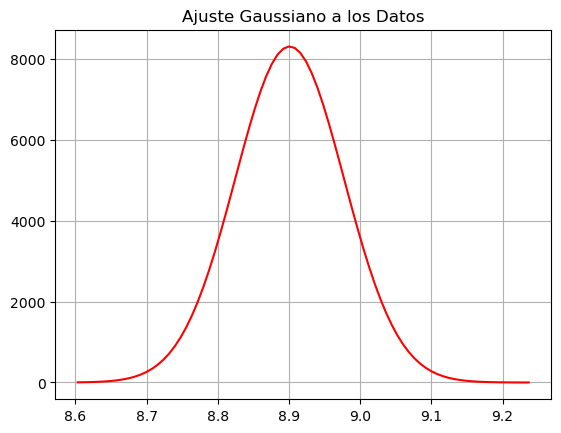

El área del pico es 1591.8


In [976]:
area6 = ajustar_area_pico(8.6, 9.25, [8000, 8.9, 0.2])

#### Segmento 3

Energía de picos:
14.92954
16.74163


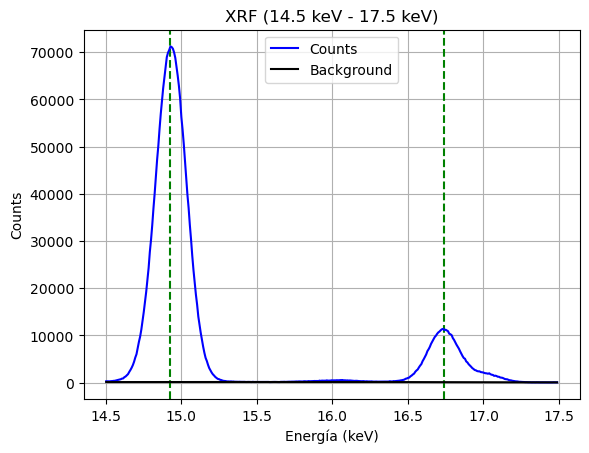

El pico principal es el Kα1 de Y, con energía de 14.96 keV
El pico derecho es el Kβ1 de Y, con energía de 16.74 keV


In [977]:
plot_data(energy, counts, background, initial_energy=14.5, final_energy=17.5, peaks=peaks[6:8], out_energy=True)
print("El pico principal es el Kα1 de Y, con energía de 14.96 keV")
print("El pico derecho es el Kβ1 de Y, con energía de 16.74 keV")

##### Pico 7

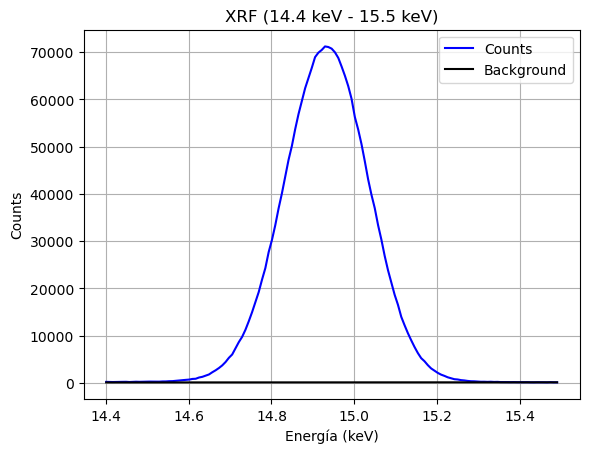

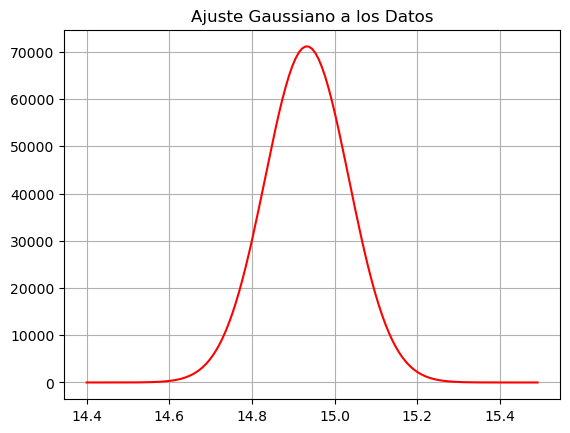

El área del pico es 18087.0


In [978]:
area7 = ajustar_area_pico(14.4, 15.5, [70000, 15, 0.2])

##### Pico 8

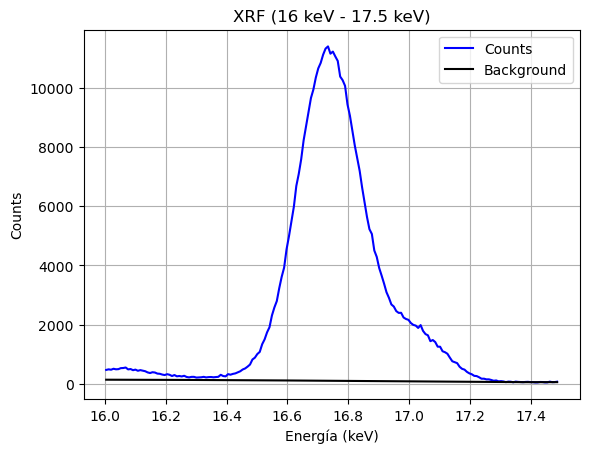

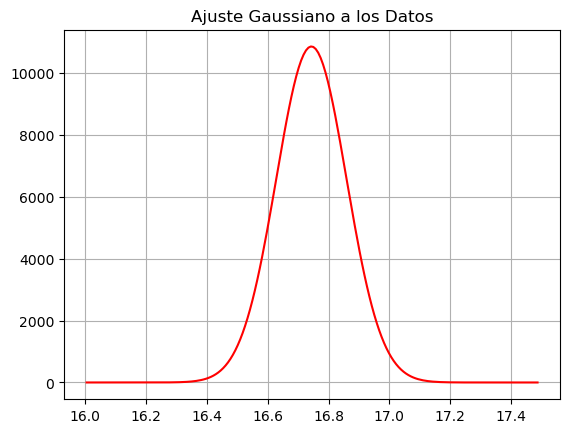

El área del pico es 3145.0


In [979]:
area8 = ajustar_area_pico(16, 17.5, [10000, 16.8, 0.2])

#### Segmento 4

Energía de picos:
22.93163


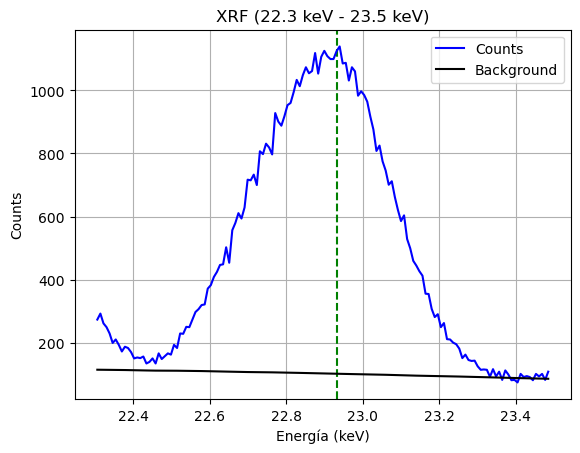

El pico es (posiblemente) el Kα2 de Cd, con energía de 22.98 keV


In [980]:
plot_data(energy, counts, background, initial_energy=22.3, final_energy=23.5, peaks=peaks[8:9], out_energy=True)
print("El pico es (posiblemente) el Kα2 de Cd, con energía de 22.98 keV")

##### Pico 9

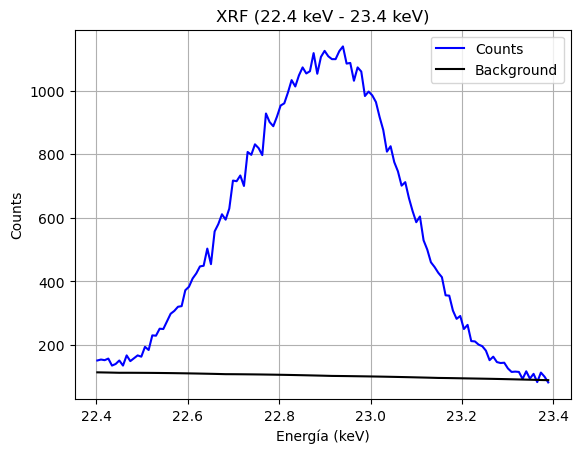

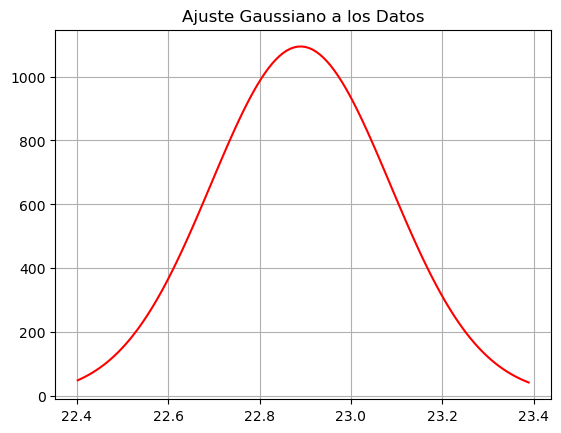

El área del pico es 530.7


In [982]:
area9 = ajustar_area_pico(22.4, 23.4, [1000, 22.9, 0.2])

## Areas 


In [981]:
area_Ba += area1 + area2 + area3 
area_Fe += area4
area_Cu += area5 + area6
area_Y += area7 + area8
area_Cd += area9